## GPyTorch

Our aim: 
- given a known model (currently GP with various priors)
- and a ground truth
- infer "missing values"


GPyTorch's approach:
- setup very simple model
- 1 single piece of training data to observe
- test_x: set of points 

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from jax import random
import jax.numpy as jnp
import numpy as onp
import numpyro
from numpyro.infer import Predictive

numpyro.set_host_device_count(3)


In [17]:
from reusable.kernels import esq_kernel

args = {
    # GP prior configuration
    "n": 100,
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}
args.update({ # so we can use the definition of n to define x
    
    "x": jnp.arange(0, args["n"] / 100, 1/100),

    # VAE configuration
    "hidden_dim1": 35,
    "hidden_dim2": 32,
    "latent_dim": 30,
    "vae_var": 0.1,

    # learning
    "num_epochs": 50,
    "learning_rate": 1.0e-3,
    "batch_size": 400,
    "train_num_batches": 500,
    "test_num_batches": 2,

    # MCMC parameters
    "num_warmup": 1000,
    "num_samples": 1000,
    "thinning": 1,
    "num_chains": 3,

    "length_prior_choice": "invgamma",
    "length_prior_arguments": {"concentration": 4.0, "rate": 1.0},
    "variance_prior_choice": "lognormal",
    "variance_prior_arguments": {"concentration": 0.0, "rate": 0.1},

    "obs_fracs": [0.02, 0.04, 0.08, 0.12, 0.15, 0.2]

})

rng_key, _ = random.split(random.PRNGKey(4))

from reusable.gp import BuildGP

gp = BuildGP(
    args["gp_kernel"],
    noise=True,
    length_prior_choice=args["length_prior_choice"],
    length_prior_args=args["length_prior_arguments"],
    variance_prior_choice=args["variance_prior_choice"],
    variance_prior_args=args["variance_prior_arguments"],
)



rng_key_ground_truth = random.PRNGKey(
    10
)  # fixed to generate a "ground truth" GP we will try and infer

rng_key_ground_truth, rng_key_obs = random.split(rng_key_ground_truth, 2)

ground_truth_predictive = Predictive(gp, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"], noise=True
)
ground_truth = gt_draws["f"].T
ground_truth_y_draw = gt_draws["y"].T
ground_truth_torch = torch.from_numpy(onp.array(ground_truth.T)[0])

ground_truth_y_draw_torch = torch.from_numpy(onp.array(ground_truth_y_draw.T)[0])

obs_idx_lst = []

for i, frac in enumerate(args["obs_fracs"]):
    num_obs = int(frac * args["n"])
    obs_mask = jnp.concatenate((jnp.full((num_obs), True), jnp.full((args["n"]-num_obs), False)))
    obs_mask = random.permutation(random.fold_in(rng_key_obs, i), obs_mask)

    
    obs_idx_lst.append(torch.tensor([x for x in range(args["n"]) if obs_mask[x]==True]))

In [18]:
from torch.nn import Module as TModule


class InverseGammaPrior(gpytorch.priors.Prior, torch.distributions.TransformedDistribution):
    """Gamma Prior parameterized by concentration and rate

    pdf(x) = beta^alpha / Gamma(alpha) * x^(alpha - 1) * exp(-beta * x)

    where alpha > 0 and beta > 0 are the concentration and rate parameters, respectively.
    """

    def __init__(self, concentration, rate, validate_args=False, transform=None):
        TModule.__init__(self)
        base_dist = torch.distributions.Gamma(concentration, rate)
        torch.distributions.TransformedDistribution.__init__(
            self,
            base_dist,
            torch.distributions.PowerTransform(-base_dist.rate.new_ones(())),
            validate_args=validate_args,
        )
        #_bufferize_attributes(self, ("concentration", "rate"))
        self._transform = transform

    def expand(self, batch_shape):
        batch_shape = torch.Size(batch_shape)
        return InverseGammaPrior(self.concentration.expand(batch_shape), self.rate.expand(batch_shape))

    def __call__(self, *args, **kwargs):
        return super(torch.distributions.TransformedDistribution, self).__call__(*args, **kwargs)


In [19]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=InverseGammaPrior(4.0, 1.0)),
            outputscale_prior=gpytorch.priors.LogNormalPrior(0.0, 0.1),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


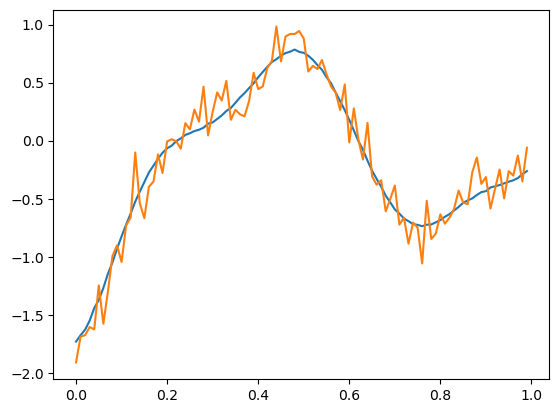

In [20]:
plt.plot(args["x"], ground_truth_torch)
plt.plot(args["x"], ground_truth_y_draw_torch)

In [21]:
# Training data is 100 points in [0,1] inclusive regularly spaced

#indices = torch.linspace(0, 98, 50, dtype=int)

train_xs = [torch.linspace(0, args["n"]/100, args["n"])[indices] for indices in obs_idx_lst]
# True function is sin(2*pi*x) with Gaussian noise
train_ys = [ground_truth_y_draw_torch[indices] for indices in obs_idx_lst]

In [22]:
def train_model(train_x, train_y, training_iter=500):
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i % 50 ==0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

    return model, likelihood

In [27]:
def evaluate_model(model, likelihood, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
    with torch.no_grad():
        # Initialize plot

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
    return observed_pred.mean.numpy(), lower.numpy(), upper.numpy()


def plot_evaluations(train_xs, train_ys, test_x, observed_means, lowers, uppers):
    assert len(observed_means) == len(lowers) and len(lowers) == len(uppers)

    f, axs = plt.subplots(1, len(observed_means), figsize=(len(observed_means) *6, 6))
    
    for i in range(len(observed_means)):
        # Plot training data as black stars
        axs[i].plot(train_xs[i], train_ys[i], 'k*')
        # Plot predictive means as blue line
        axs[i].plot(test_x.numpy(), observed_means[i], 'b')

        axs[i].plot(test_x, ground_truth, 'r')
        # Shade between the lower and upper confidence bounds
        axs[i].fill_between(test_x.numpy(), lowers[i], uppers[i], alpha=0.5)
        axs[i].set_ylim([-4, 4])
        axs[i].legend(['Observed Data', 'Mean', "Ground truth (with noise)", 'Confidence'])

In [29]:
means = []
lowers = []
uppers = []

test_x =  torch.linspace(0, args["n"]/100, args["n"])

for i in range(len(obs_idx_lst)):
    model, likelihood = train_model(train_xs[i], train_ys[i])

    mean, lower, upper = evaluate_model(model, likelihood, test_x)
    means.append(mean)
    lowers.append(lower)
    uppers.append(upper)


Iter 1/500 - Loss: 4.264   lengthscale: 0.693   noise: 0.693
Iter 51/500 - Loss: -0.500   lengthscale: 0.222   noise: 0.030
Iter 101/500 - Loss: -0.521   lengthscale: 0.217   noise: 0.011
Iter 151/500 - Loss: -0.525   lengthscale: 0.217   noise: 0.006
Iter 201/500 - Loss: -0.527   lengthscale: 0.217   noise: 0.004
Iter 251/500 - Loss: -0.528   lengthscale: 0.217   noise: 0.003
Iter 301/500 - Loss: -0.528   lengthscale: 0.217   noise: 0.002
Iter 351/500 - Loss: -0.529   lengthscale: 0.217   noise: 0.002
Iter 401/500 - Loss: -0.529   lengthscale: 0.217   noise: 0.002
Iter 451/500 - Loss: -0.529   lengthscale: 0.217   noise: 0.001
Iter 1/500 - Loss: 3.064   lengthscale: 0.693   noise: 0.693
Iter 51/500 - Loss: 0.306   lengthscale: 0.203   noise: 0.014
Iter 101/500 - Loss: 0.300   lengthscale: 0.197   noise: 0.016
Iter 151/500 - Loss: 0.300   lengthscale: 0.196   noise: 0.016
Iter 201/500 - Loss: 0.300   lengthscale: 0.196   noise: 0.016
Iter 251/500 - Loss: 0.300   lengthscale: 0.196   no

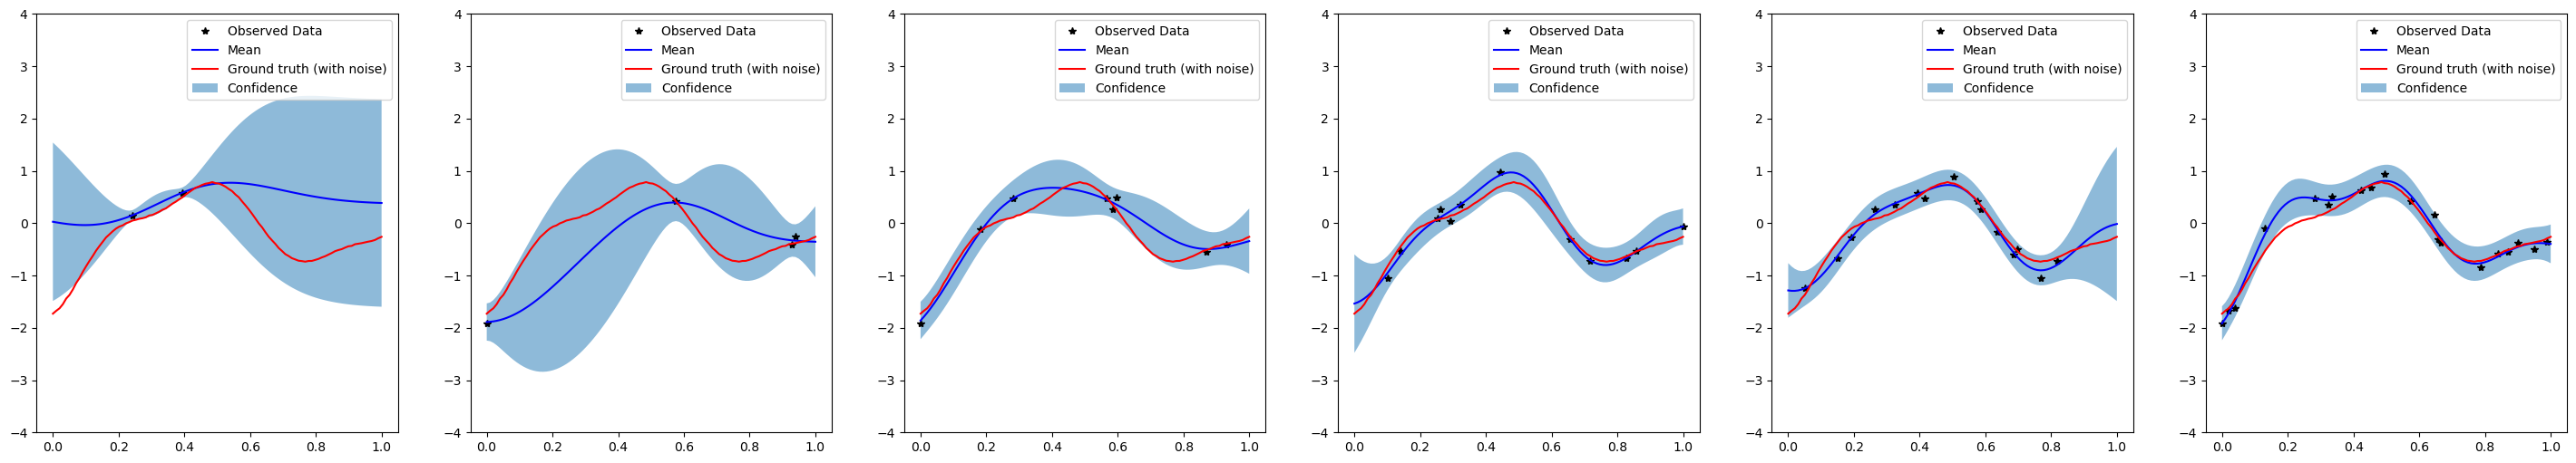

In [30]:

plot_evaluations(train_xs, train_ys, test_x, means, lowers, uppers)